In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Needed for API key
from dotenv import load_dotenv
import os
import requests

In [2]:
stock = 'GME'
load_dotenv()
key = os.getenv('key')

In [3]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock}&apikey={key}'
r = requests.get(url)
data = r.json()

In [4]:
data['Meta Data']

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'GME',
 '3. Last Refreshed': '2025-05-15',
 '4. Output Size': 'Compact',
 '5. Time Zone': 'US/Eastern'}

In [5]:
gme_data = data['Time Series (Daily)']

In [6]:
df = pd.DataFrame.from_dict(gme_data, orient = 'index')
df.index = pd.to_datetime(df.index)
df = df.astype(float)
df = df.sort_index()
df

,1. open,2. high,3. low,4. close,5. volume
2024-12-19,29.155,30.6000,28.8200,29.00,10338215.0
2024-12-20,28.540,30.5200,28.3093,29.82,19606720.0
2024-12-23,29.820,31.1100,29.7802,30.90,8226542.0
2024-12-24,31.000,31.5940,30.5800,31.14,5523507.0
2024-12-26,32.620,34.3700,31.6000,32.99,20510653.0
...,...,...,...,...,...
2025-05-09,26.780,27.7300,26.7600,27.54,7795212.0
2025-05-12,28.060,28.1800,27.2850,28.05,7395242.0
2025-05-13,28.050,28.8599,28.0500,28.39,10365258.0
2025-05-14,28.480,29.3900,28.3000,28.73,14552315.0


In [7]:
# get rid of 1s and 2s in front of column names
df.columns = df.columns.str.replace(r"^\d+\.\s*", "", regex=True)

In [8]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [9]:
df.shape

(100, 5)

In [10]:
df.groupby(df.index.date).size()

2024-12-19    1
2024-12-20    1
2024-12-23    1
2024-12-24    1
2024-12-26    1
             ..
2025-05-09    1
2025-05-12    1
2025-05-13    1
2025-05-14    1
2025-05-15    1
Length: 100, dtype: int64

In [11]:
start_date = df.index.min().date().strftime('%Y%m%d')
end_date = df.index.max().date().strftime('%Y%m%d')

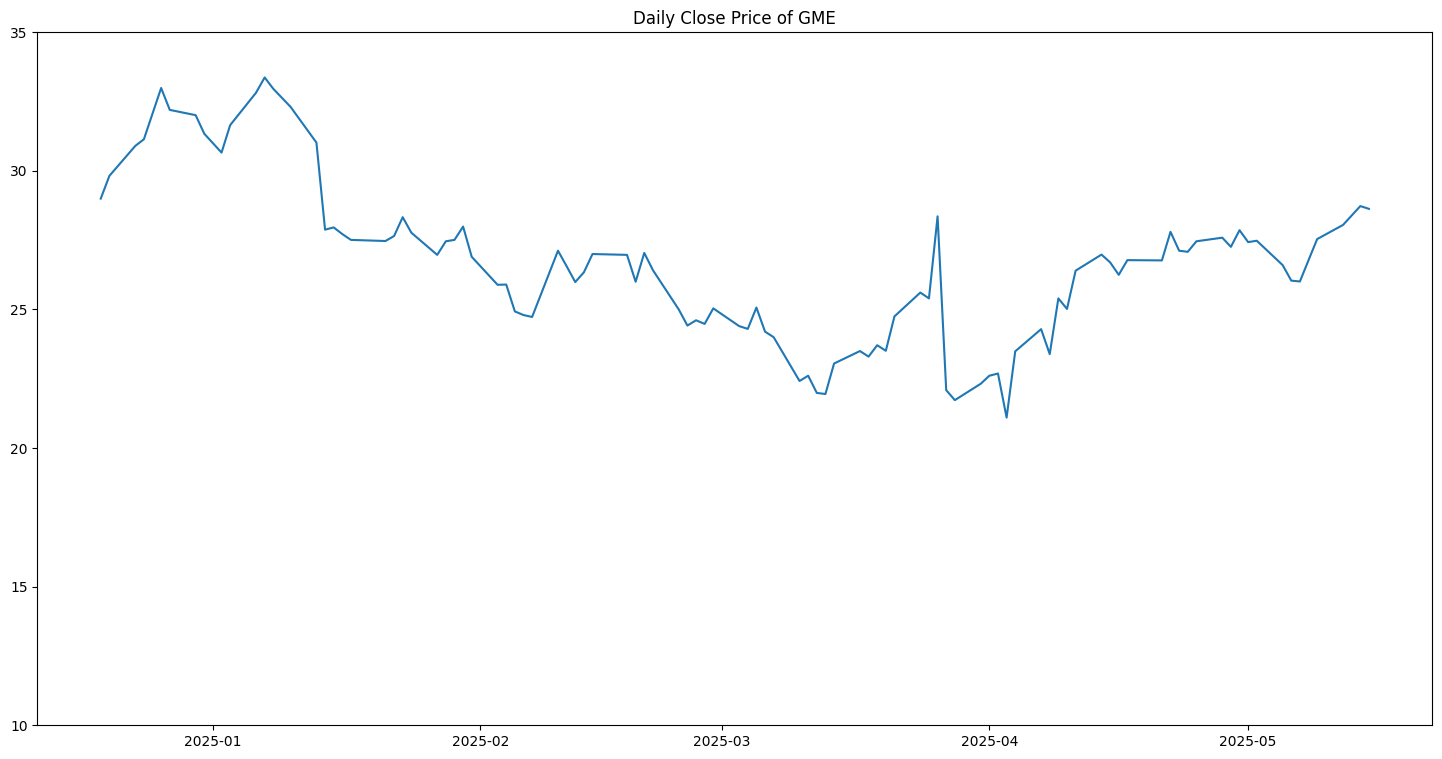

In [12]:
plt.figure(figsize = (18,9))
plt.plot(df['close'])
plt.title('Daily Close Price of GME')
plt.yticks(range(10,40,5));

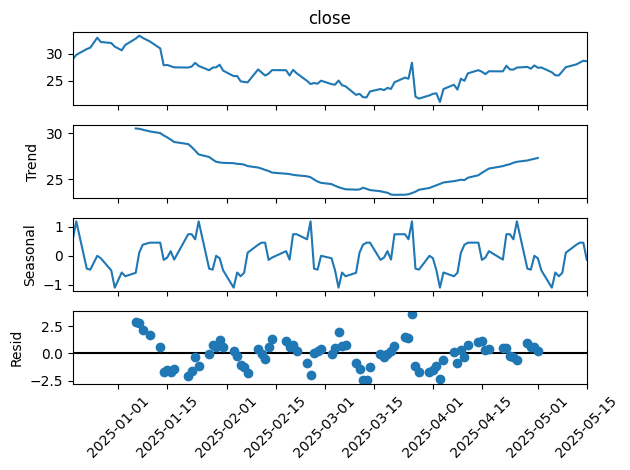

In [13]:
decomp = seasonal_decompose(df['close'],model='additive', period = 21)
fig = decomp.plot()

# Rotate only the Resid x-axis 45 degrees so it is legible
resid_ax = fig.axes[-1]
for label in resid_ax.get_xticklabels():
    label.set_rotation(45)

plt.tight_layout()
plt.show()

# Get in News

In [14]:
news_url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={stock}&time_from={start_date}T0000&time_to={end_date}T0000&apikey={key}'
r = requests.get(news_url)
data = r.json()

In [15]:
feed_items = data['feed']

In [16]:
feed_items

[{'title': 'GameStop  ( GME )  Rises Higher Than Market: Key Facts',
  'url': 'https://www.zacks.com/stock/news/2469614/gamestop-gme-rises-higher-than-market-key-facts',
  'time_published': '20250513T214516',
  'authors': ['Zacks Equity Research'],
  'summary': 'The latest trading day saw GameStop (GME) settling at $28.39, representing a +1.21% change from its previous close.',
  'banner_image': 'https://staticx-tuner.zacks.com/images/default_article_images/default36.jpg',
  'source': 'Zacks Commentary',
  'category_within_source': 'n/a',
  'source_domain': 'www.zacks.com',
  'topics': [{'topic': 'Earnings', 'relevance_score': '0.891286'},
   {'topic': 'Retail & Wholesale', 'relevance_score': '1.0'},
   {'topic': 'Financial Markets', 'relevance_score': '0.266143'}],
  'overall_sentiment_score': 0.302376,
  'overall_sentiment_label': 'Somewhat-Bullish',
  'ticker_sentiment': [{'ticker': 'GME',
    'relevance_score': '0.593484',
    'ticker_sentiment_score': '0.506517',
    'ticker_senti

In [17]:
flat_data = []

for article in feed_items:
    base = {
        'title': article.get('title'),
        'time_published': article.get('time_published'),
        'authors': ", ".join(article.get('authors', [])),
        'summary': article.get('summary'),
        'source': article.get('source'),
        'overall_sentiment_score': article.get('overall_sentiment_score'),
        'overall_sentiment_label': article.get('overall_sentiment_label'),
    }

    # Topics as comma-separated string
    topics = article.get('topics', [])
    topic_names = [t['topic'] for t in topics]
    base['topics'] = ", ".join(topic_names)

    # Ticker sentiment - multiple tickers possible, so one row per ticker
    for ticker_info in article.get('ticker_sentiment', []):
        if ticker_info.get('ticker') == stock:
            base['ticker'] = ticker_info.get('ticker')
            base['ticker_relevance_score'] = ticker_info.get('relevance_score')
            base['ticker_sentiment_score'] = ticker_info.get('ticker_sentiment_score')
            base['ticker_sentiment_label'] = ticker_info.get('ticker_sentiment_label')
            flat_data.append(base)
            break

news = pd.DataFrame(flat_data)

In [18]:
news

,title,time_published,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
0,GameStop ( GME ) Rises Higher Than Market: K...,20250513T214516,Zacks Equity Research,The latest trading day saw GameStop (GME) sett...,Zacks Commentary,0.302376,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.593484,0.506517,Bullish
1,"Rocket Companies Is Citron's Top Pick, 'Amazon...",20250513T162059,Chris Katje,Short Seller Citron Research shares a new long...,Benzinga,0.149170,Neutral,"Real Estate & Construction, Retail & Wholesale...",GME,0.068896,0.174835,Somewhat-Bullish
2,Bitcoin remains unmatched as a global inflatio...,20250513T150000,Jupiter Zheng,"Opinion by: Jupiter Zheng, Partner Liquid Fund...",Cointelegraph,-0.184396,Somewhat-Bearish,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.044551,0.001,Neutral
3,GameStop Trading at a Premium: Should You Rest...,20250512T131500,Sumit Singh,"GameStop is evolving, but is its high valuatio...",Zacks Commentary,0.312549,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Earning...",GME,0.60244,0.44727,Bullish
4,Where Will Palantir Stock Be in 3 Years?,20250509T113000,Will Ebiefung,"With its shares up 58% year to date, Palantir ...",Motley Fool,0.131610,Neutral,"IPO, Retail & Wholesale, Financial Markets, Ma...",GME,0.065866,-0.048667,Neutral
5,Metaplanet is raising another $21M through bon...,20250509T061818,Stephen Katte,"Fresh off its most recent Bitcoin purchase, Ja...",Cointelegraph,0.080201,Neutral,"Retail & Wholesale, Financial Markets, Mergers...",GME,0.211191,0.107285,Neutral
6,GameStop ( GME ) Stock Sinks As Market Gains...,20250507T214512,Zacks Equity Research,The latest trading day saw GameStop (GME) sett...,Zacks Commentary,0.235485,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.4499,0.320818,Somewhat-Bullish
7,Bitcoin for Shares? Strive Asset Management Un...,20250507T205715,André Beganski,Strive Asset Management is adopting Bitcoin as...,Decrypt.co,0.135833,Neutral,"IPO, Retail & Wholesale, Financial Markets, Te...",GME,0.163354,0.233091,Somewhat-Bullish
8,Is Nuveen ESG Small-Cap ETF ( NUSC ) a Stron...,20250507T102005,Zacks Equity Research,Smart Beta ETF report for ...,Zacks Commentary,0.225040,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.116914,0.054712,Neutral
9,Billionaire Bill Ackman Thinks Hertz Stock Cou...,20250506T140700,Adam Spatacco,Certain personalities on Wall Street have the ...,Motley Fool,0.167199,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.049835,0.06195,Neutral


In [19]:
news.isnull().sum()

title                      0
time_published             0
authors                    0
summary                    0
source                     0
overall_sentiment_score    0
overall_sentiment_label    0
topics                     0
ticker                     0
ticker_relevance_score     0
ticker_sentiment_score     0
ticker_sentiment_label     0
dtype: int64

In [20]:
news.shape

(50, 12)

In [21]:
news['authors'].unique()

array(['Zacks Equity Research', 'Chris Katje', 'Jupiter Zheng',
       'Sumit Singh', 'Will Ebiefung', 'Stephen Katte', 'André Beganski',
       'Adam Spatacco', 'PRNewswire', 'Benzinga Insights',
       'Christopher Tepedino', 'Andrew Rocco', 'Surbhi Jain',
       'Brayden Lindrea', 'Brian Bolan', 'Adam Eckert', 'Henry Khederian',
       'Globe Newswire', 'Bram Berkowitz', 'Rishabh Mishra',
       'Vaishali Prayag', 'Aniket Verma', 'Motley Fool Staff',
       'Derek Lewis', 'Ritujay Ghosh', 'Sanghamitra Saha', 'Nalak Das',
       'Akanksha Bakshi'], dtype=object)

In [22]:
news['time_published'] = news['time_published'].str[:8]
news['time_published'] = pd.to_datetime(news['time_published'], format = '%Y%m%d')
news = news.set_index('time_published')

In [23]:
news

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-05-13,GameStop ( GME ) Rises Higher Than Market: K...,Zacks Equity Research,The latest trading day saw GameStop (GME) sett...,Zacks Commentary,0.302376,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.593484,0.506517,Bullish
2025-05-13,"Rocket Companies Is Citron's Top Pick, 'Amazon...",Chris Katje,Short Seller Citron Research shares a new long...,Benzinga,0.149170,Neutral,"Real Estate & Construction, Retail & Wholesale...",GME,0.068896,0.174835,Somewhat-Bullish
2025-05-13,Bitcoin remains unmatched as a global inflatio...,Jupiter Zheng,"Opinion by: Jupiter Zheng, Partner Liquid Fund...",Cointelegraph,-0.184396,Somewhat-Bearish,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.044551,0.001,Neutral
2025-05-12,GameStop Trading at a Premium: Should You Rest...,Sumit Singh,"GameStop is evolving, but is its high valuatio...",Zacks Commentary,0.312549,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Earning...",GME,0.60244,0.44727,Bullish
2025-05-09,Where Will Palantir Stock Be in 3 Years?,Will Ebiefung,"With its shares up 58% year to date, Palantir ...",Motley Fool,0.131610,Neutral,"IPO, Retail & Wholesale, Financial Markets, Ma...",GME,0.065866,-0.048667,Neutral
2025-05-09,Metaplanet is raising another $21M through bon...,Stephen Katte,"Fresh off its most recent Bitcoin purchase, Ja...",Cointelegraph,0.080201,Neutral,"Retail & Wholesale, Financial Markets, Mergers...",GME,0.211191,0.107285,Neutral
2025-05-07,GameStop ( GME ) Stock Sinks As Market Gains...,Zacks Equity Research,The latest trading day saw GameStop (GME) sett...,Zacks Commentary,0.235485,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.4499,0.320818,Somewhat-Bullish
2025-05-07,Bitcoin for Shares? Strive Asset Management Un...,André Beganski,Strive Asset Management is adopting Bitcoin as...,Decrypt.co,0.135833,Neutral,"IPO, Retail & Wholesale, Financial Markets, Te...",GME,0.163354,0.233091,Somewhat-Bullish
2025-05-07,Is Nuveen ESG Small-Cap ETF ( NUSC ) a Stron...,Zacks Equity Research,Smart Beta ETF report for ...,Zacks Commentary,0.225040,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.116914,0.054712,Neutral


In [24]:
news.groupby(news.index.date).size()

2025-04-08    2
2025-04-09    1
2025-04-10    2
2025-04-11    4
2025-04-14    2
2025-04-15    1
2025-04-16    2
2025-04-17    2
2025-04-18    1
2025-04-21    1
2025-04-22    2
2025-04-23    4
2025-04-24    5
2025-04-25    5
2025-04-28    1
2025-04-29    1
2025-04-30    1
2025-05-02    1
2025-05-05    2
2025-05-06    1
2025-05-07    3
2025-05-09    2
2025-05-12    1
2025-05-13    3
dtype: int64

In [25]:
news[news['authors'] == '']

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,


In [26]:
news.loc[news['authors'] == '', 'authors'] = 'Unknown Author'
news

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-05-13,GameStop ( GME ) Rises Higher Than Market: K...,Zacks Equity Research,The latest trading day saw GameStop (GME) sett...,Zacks Commentary,0.302376,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.593484,0.506517,Bullish
2025-05-13,"Rocket Companies Is Citron's Top Pick, 'Amazon...",Chris Katje,Short Seller Citron Research shares a new long...,Benzinga,0.149170,Neutral,"Real Estate & Construction, Retail & Wholesale...",GME,0.068896,0.174835,Somewhat-Bullish
2025-05-13,Bitcoin remains unmatched as a global inflatio...,Jupiter Zheng,"Opinion by: Jupiter Zheng, Partner Liquid Fund...",Cointelegraph,-0.184396,Somewhat-Bearish,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.044551,0.001,Neutral
2025-05-12,GameStop Trading at a Premium: Should You Rest...,Sumit Singh,"GameStop is evolving, but is its high valuatio...",Zacks Commentary,0.312549,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Earning...",GME,0.60244,0.44727,Bullish
2025-05-09,Where Will Palantir Stock Be in 3 Years?,Will Ebiefung,"With its shares up 58% year to date, Palantir ...",Motley Fool,0.131610,Neutral,"IPO, Retail & Wholesale, Financial Markets, Ma...",GME,0.065866,-0.048667,Neutral
2025-05-09,Metaplanet is raising another $21M through bon...,Stephen Katte,"Fresh off its most recent Bitcoin purchase, Ja...",Cointelegraph,0.080201,Neutral,"Retail & Wholesale, Financial Markets, Mergers...",GME,0.211191,0.107285,Neutral
2025-05-07,GameStop ( GME ) Stock Sinks As Market Gains...,Zacks Equity Research,The latest trading day saw GameStop (GME) sett...,Zacks Commentary,0.235485,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.4499,0.320818,Somewhat-Bullish
2025-05-07,Bitcoin for Shares? Strive Asset Management Un...,André Beganski,Strive Asset Management is adopting Bitcoin as...,Decrypt.co,0.135833,Neutral,"IPO, Retail & Wholesale, Financial Markets, Te...",GME,0.163354,0.233091,Somewhat-Bullish
2025-05-07,Is Nuveen ESG Small-Cap ETF ( NUSC ) a Stron...,Zacks Equity Research,Smart Beta ETF report for ...,Zacks Commentary,0.225040,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.116914,0.054712,Neutral


In [27]:
news['overall_sentiment_label'].unique()

array(['Somewhat-Bullish', 'Neutral', 'Somewhat-Bearish', 'Bullish'],
      dtype=object)

In [28]:
news['ticker_sentiment_label'].unique()

array(['Bullish', 'Somewhat-Bullish', 'Neutral'], dtype=object)

In [29]:
news['overall_sentiment_label'] = news['overall_sentiment_label'].replace({
    'Somewhat-Bullish': 4, 
    'Neutral': 3, 
    'Bullish': 5, 
    'Somewhat-Bearish': 2,
    'Bearish': 1
})
news['ticker_sentiment_label'] = news['ticker_sentiment_label'].replace({
    'Somewhat-Bullish': 4, 
    'Neutral': 3, 
    'Bullish': 5, 
    'Somewhat-Bearish': 2,
    'Bearish': 1
})

C:\Users\graha\AppData\Local\Temp\ipykernel_8956\3453675565.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news['overall_sentiment_label'] = news['overall_sentiment_label'].replace({
C:\Users\graha\AppData\Local\Temp\ipykernel_8956\3453675565.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news['ticker_sentiment_label'] = news['ticker_sentiment_label'].replace({


# Merge both DataFrames

In [30]:
merged_df = df.merge(news,how = 'left',left_index = True, right_index = True)
merged_df = merged_df.fillna(0)
merged_df

,open,high,low,close,volume,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
2024-12-19,29.155,30.6000,28.8200,29.00,10338215.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-12-20,28.540,30.5200,28.3093,29.82,19606720.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-12-23,29.820,31.1100,29.7802,30.90,8226542.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-12-24,31.000,31.5940,30.5800,31.14,5523507.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-12-26,32.620,34.3700,31.6000,32.99,20510653.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-13,28.050,28.8599,28.0500,28.39,10365258.0,GameStop ( GME ) Rises Higher Than Market: K...,Zacks Equity Research,The latest trading day saw GameStop (GME) sett...,Zacks Commentary,0.302376,4.0,"Earnings, Retail & Wholesale, Financial Markets",GME,0.593484,0.506517,5.0
2025-05-13,28.050,28.8599,28.0500,28.39,10365258.0,"Rocket Companies Is Citron's Top Pick, 'Amazon...",Chris Katje,Short Seller Citron Research shares a new long...,Benzinga,0.149170,3.0,"Real Estate & Construction, Retail & Wholesale...",GME,0.068896,0.174835,4.0
2025-05-13,28.050,28.8599,28.0500,28.39,10365258.0,Bitcoin remains unmatched as a global inflatio...,Jupiter Zheng,"Opinion by: Jupiter Zheng, Partner Liquid Fund...",Cointelegraph,-0.184396,2.0,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.044551,0.001,3.0
2025-05-14,28.480,29.3900,28.3000,28.73,14552315.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0


In [31]:
merged_df.dtypes

open                       float64
high                       float64
low                        float64
close                      float64
volume                     float64
title                       object
authors                     object
summary                     object
source                      object
overall_sentiment_score    float64
overall_sentiment_label    float64
topics                      object
ticker                      object
ticker_relevance_score      object
ticker_sentiment_score      object
ticker_sentiment_label     float64
dtype: object

In [32]:
merged_df['ticker_relevance_score'] = merged_df['ticker_relevance_score'].astype(float)
merged_df['ticker_sentiment_score'] = merged_df['ticker_sentiment_score'].astype(float)

In [33]:
merged_df = merged_df.drop(columns = ['title','topics','ticker','authors','summary','source'])
merged_df

,open,high,low,close,volume,overall_sentiment_score,overall_sentiment_label,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
2024-12-19,29.155,30.6000,28.8200,29.00,10338215.0,0.000000,0.0,0.000000,0.000000,0.0
2024-12-20,28.540,30.5200,28.3093,29.82,19606720.0,0.000000,0.0,0.000000,0.000000,0.0
2024-12-23,29.820,31.1100,29.7802,30.90,8226542.0,0.000000,0.0,0.000000,0.000000,0.0
2024-12-24,31.000,31.5940,30.5800,31.14,5523507.0,0.000000,0.0,0.000000,0.000000,0.0
2024-12-26,32.620,34.3700,31.6000,32.99,20510653.0,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-05-13,28.050,28.8599,28.0500,28.39,10365258.0,0.302376,4.0,0.593484,0.506517,5.0
2025-05-13,28.050,28.8599,28.0500,28.39,10365258.0,0.149170,3.0,0.068896,0.174835,4.0
2025-05-13,28.050,28.8599,28.0500,28.39,10365258.0,-0.184396,2.0,0.044551,0.001000,3.0
2025-05-14,28.480,29.3900,28.3000,28.73,14552315.0,0.000000,0.0,0.000000,0.000000,0.0


## LSTM Model

In [34]:
# Split off target
features = merged_df.drop(columns=['close'])
target = merged_df[['close']]

# Normalize
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target)

# Reassemble DataFrame
scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
scaled_df['close'] = target_scaled

In [35]:
def create_lstm_dataset(data, target_column, look_back):
    """
    Convert a dataframe into LSTM-compatible 3D sequences for a specific target column.
    
    Parameters:
    - data: pandas DataFrame (rows = time, cols = features)
    - target_column: name of the column to predict (e.g., 'Close')
    - look_back: number of past time steps to include

    Returns:
    - X: shape (num_samples, look_back, num_features)
    - y: shape (num_samples,)
    """
    # Extract features and target column
    features = data.drop(columns=[target_column]).values  # All columns except target
    target = data[target_column].values  # Target column
    
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(features[i:i+look_back])  # Look-back window of features
        y.append(target[i + look_back])  # Next time-step's target value
        
    return np.array(X), np.array(y)
look_back = 10
X_all, y_all = create_lstm_dataset(scaled_df, target_column='close', look_back=look_back)

# Use all data except the final 14 days (7 for evaluation + 7 for prediction)
test_days = 7
eval_days = 7
X_train = X_all[:- (test_days + eval_days)]
y_train = y_all[:- (test_days + eval_days)]

X_eval = X_all[-(test_days + eval_days):-test_days]
y_eval = y_all[-(test_days + eval_days):-test_days]

In [36]:
# Define the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(look_back, X_train.shape[2])),
    LSTM(128, return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

C:\Users\graha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
early_stop = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=10,          # Stop after 10 epochs with no improvement
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,   # Needed for val_loss monitoring
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.1313 - val_loss: 0.1795
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0438 - val_loss: 0.0068
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0350 - val_loss: 0.0024
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0179 - val_loss: 0.0141
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0201 - val_loss: 0.0039
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0164 - val_loss: 7.5452e-04
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0192 - val_loss: 0.0035
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0130 - val_loss: 0.0120
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0127 - val_loss: 0.0020
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0152 - val_loss: 6.4186e-04
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0190 - val_loss: 0.0058
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0127

In [64]:
y_eval_pred = model.predict(X_eval)
y_eval_pred_unscaled = target_scaler.inverse_transform(y_eval_pred)
y_eval_actual_unscaled = target_scaler.inverse_transform(y_eval.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [65]:
last_window = scaled_df.drop(columns=['close']).values[-look_back:]

future_predictions_scaled = []
input_seq = last_window.copy()

for _ in range(7):  # Predict 7 days
    pred = model.predict(input_seq[np.newaxis, :, :])[0, 0]
    future_predictions_scaled.append(pred)

    # Append the prediction to the feature window (use previous features and predicted close)
    next_features = np.append(input_seq[-1, :-1], pred)  # Replace last 'close'
    input_seq = np.vstack([input_seq[1:], next_features])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [66]:
# Unscale predictions
future_preds_unscaled = target_scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

In [67]:
# Get the last available date in your dataset
last_known_date = merged_df.index[-1]

# Generate next 7 business days after last known stock price date
future_dates = pd.bdate_range(start=last_known_date + pd.Timedelta(days=1), periods=7)

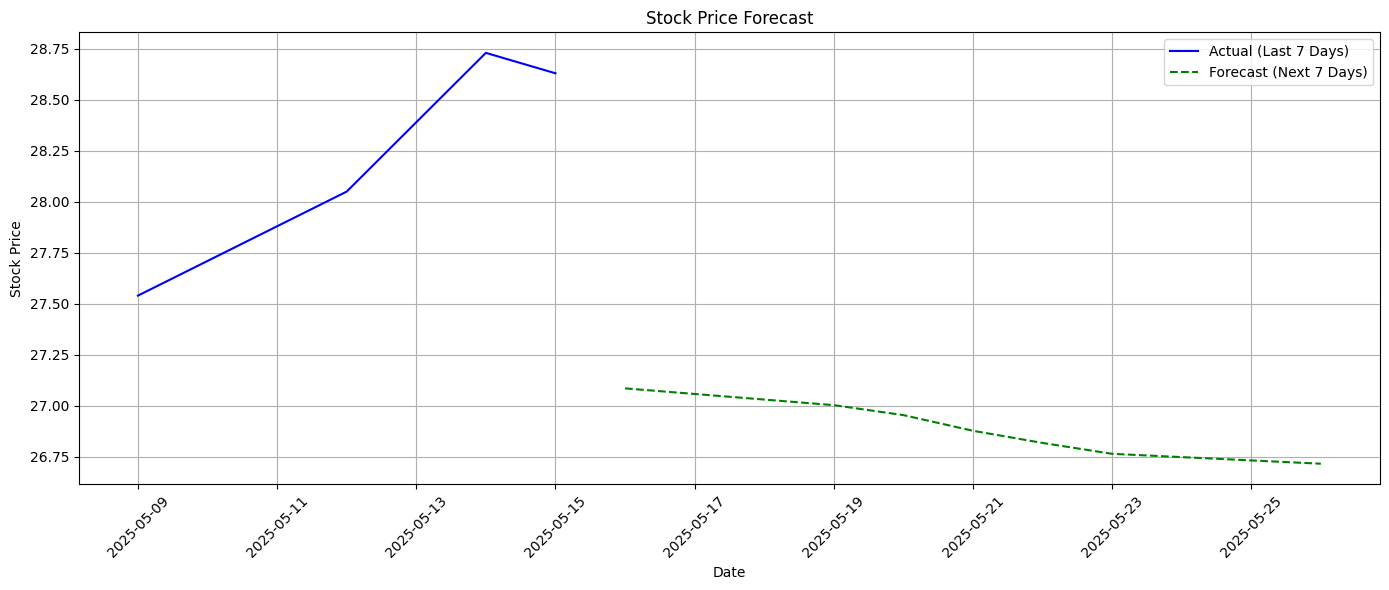

In [68]:
plt.figure(figsize=(14, 6))

# Plot actual stock prices for the last N days (e.g., last 7)
plt.plot(merged_df.index[-7:], merged_df['close'].values[-7:], label="Actual (Last 7 Days)", color="blue")

# Plot predicted prices for the next 7 business days
plt.plot(future_dates, future_preds_unscaled, label="Forecast (Next 7 Days)", color="green", linestyle='--')

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Forecast")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
